# Audio Signal Classification Project

EE 413 DSP Project using the Free-Spoken Digit Dataset (FSDD)

## Objectives

- Apply DSP techniques for audio signal classification.
- Extract and analyze time-domain, frequency-domain, and wavelet features.
- Build and evaluate a classifier for the spoken digits.

## Dataset and Tools

Describe the Free-Spoken Digit Dataset (FSDD) and list the tools and libraries that will be used.

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt
import noisereduce as nr
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
from sklearn.neighbors import KNeighborsClassifier
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt
import ipywidgets as widgets
from matplotlib.colors import LogNorm, Normalize
from IPython.display import display
from scipy import signal, interpolate
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import hub
import librosa
import librosa.display
import av
from scipy import interpolate
from scipy.io import wavfile as wav

## Data Loading and Exploratory Data Analysis (EDA)

Outline steps for loading the dataset and performing initial exploratory analysis. Include placeholders for findings and visualizations.

In [65]:

# --- Path to dataset ------------------------------------------------------
data_path = Path('free-spoken-digit-dataset/recordings')   # adjust if you moved the folder
assert data_path.is_dir(), f"Dataset not found at {data_path.resolve()}"

# --- List only .wav files -------------------------------------------------
wav_files = sorted(p for p in data_path.glob('*.wav'))
print("First 5 files:", [p.name for p in wav_files[:5]])

# --- Load the first file --------------------------------------------------
audio, sr = librosa.load(wav_files[0], sr=None)    # sr=None keeps original 8 kHz
print(f"Sample rate: {sr} Hz   |   Audio shape: {audio.shape}")


First 5 files: ['0_george_0.wav', '0_george_1.wav', '0_george_10.wav', '0_george_11.wav', '0_george_12.wav']
Sample rate: 8000 Hz   |   Audio shape: (2384,)


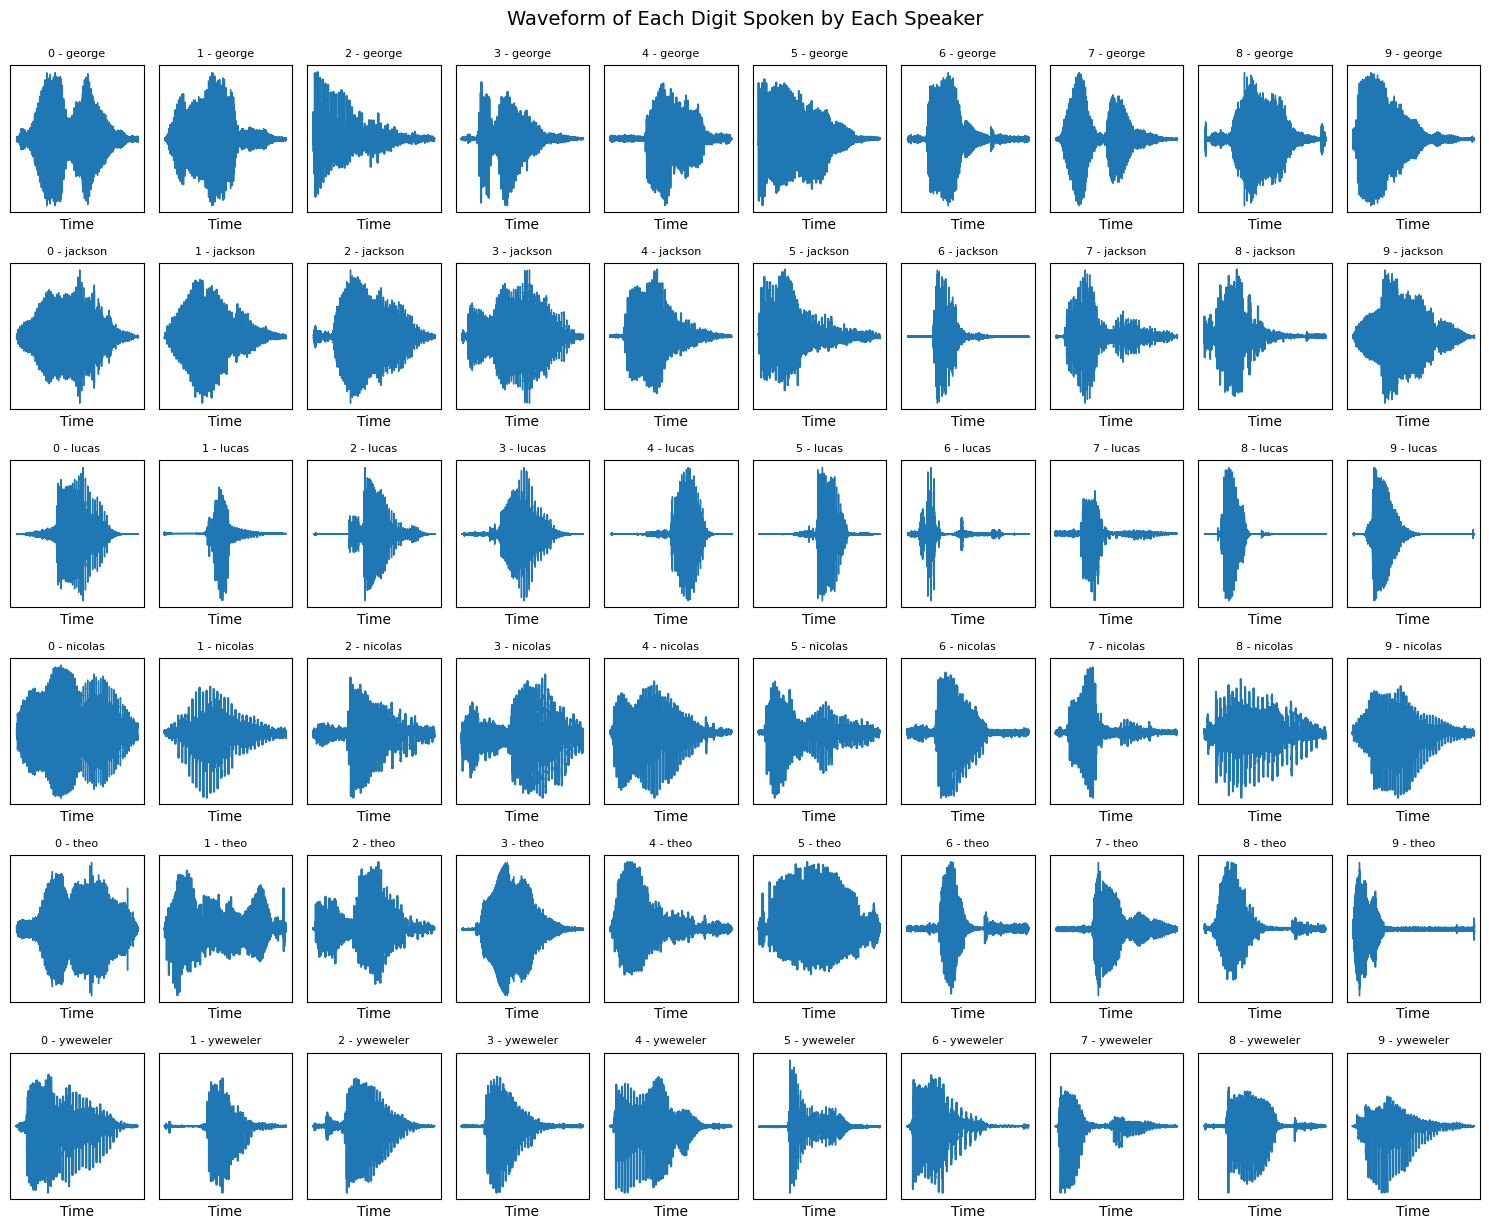

In [9]:

# Load all recordings
data_path = 'free-spoken-digit-dataset/recordings'
files = [f for f in os.listdir(data_path) if f.endswith('.wav')]

# Extract unique digits and speakers
digits = list(range(10))
speakers = sorted(set(f.split('_')[1] for f in files))

# Prepare figure grid
plt.figure(figsize=(15, len(speakers) * 2))

plot_num = 1

for speaker in speakers:
    for digit in digits:
        # Find one matching file
        match = [f for f in files if f.startswith(f"{digit}_{speaker}")]
        if not match:
            continue
        filepath = os.path.join(data_path, match[0])
        y, sr = librosa.load(filepath)

        # Plot waveform the snippet below into a new code cell and run it once; all your original plotting cells will then work unchanged.
        plt.subplot(len(speakers), len(digits), plot_num)
        librosa.display.waveshow(y, sr=sr)
        plt.xticks([]); plt.yticks([])
        plt.title(f'{digit} - {speaker}', fontsize=8)
        plot_num += 1

plt.tight_layout()
plt.suptitle('Waveform of Each Digit Spoken by Each Speaker', fontsize=14, y=1.02)
plt.show()


In [13]:
# ── New helper cell: build df from your existing variables ────────────────
import pandas as pd
import librosa
from pathlib import Path
import os

# Ensure 'data_path' and 'files' already exist (they do in your notebook)
assert 'data_path' in globals() and 'files' in globals(), "Run the dataset‑loading cell first."

metadata = []
for fname in files:                     # use the same 'files' list you built earlier
    try:
        digit, speaker, index = fname.split('_')
        index = index.split('.')[0]     # strip ".wav"
        filepath = Path(data_path) / fname
        duration = librosa.get_duration(path=str(filepath))
        metadata.append({
            'digit': int(digit),
            'speaker': speaker,
            'index': int(index),
            'duration': duration,
            'filepath': str(filepath)
        })
    except Exception as e:
        print(f"Skipping {fname}: {e}")

df = pd.DataFrame(metadata)
print(f"df built with {len(df)} rows and columns {list(df.columns)}")


df built with 3000 rows and columns ['digit', 'speaker', 'index', 'duration', 'filepath']


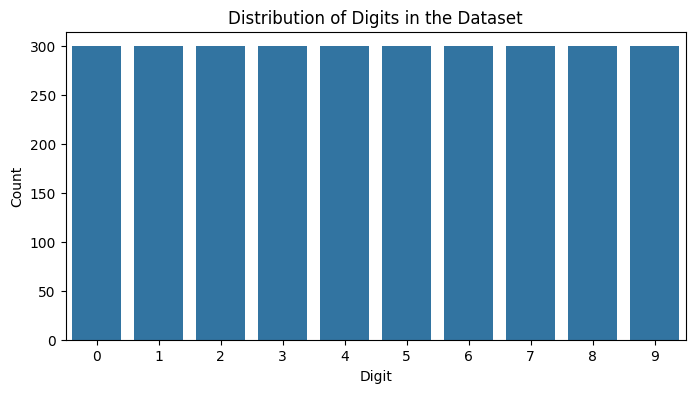

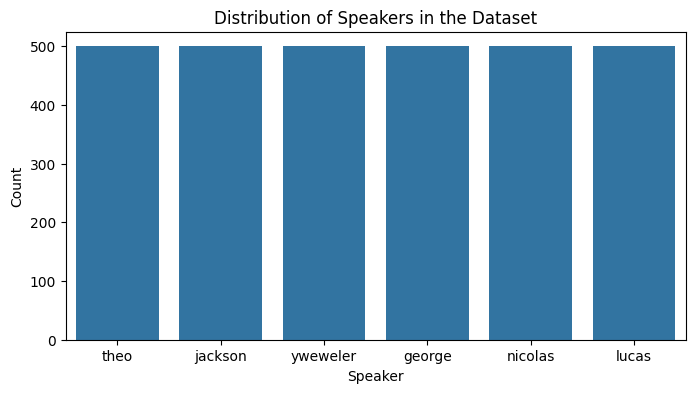

In [14]:

# Plot 1: Distribution of digits
plt.figure(figsize=(8, 4))
sns.countplot(x='digit', data=df)
plt.title('Distribution of Digits in the Dataset')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

# Plot 2: Distribution of speakers
plt.figure(figsize=(8, 4))
sns.countplot(x='speaker', data=df)
plt.title('Distribution of Speakers in the Dataset')
plt.xlabel('Speaker')
plt.ylabel('Count')
plt.show()

🔢 General Stats:
            digit     duration
count  3000.00000  3000.000000
mean      4.50000     0.437434
std       2.87276     0.147643
min       0.00000     0.143500
25%       2.00000     0.342344
50%       4.50000     0.419813
75%       7.00000     0.510281
max       9.00000     2.282750

📊 Duration by Digit:
           mean    median       min       max       std
digit                                                  
0      0.504021  0.491500  0.271750  1.167625  0.125389
1      0.405509  0.377750  0.174875  1.004500  0.132164
2      0.383915  0.356563  0.161000  1.213375  0.136892
3      0.400331  0.384062  0.181875  1.313000  0.151184
4      0.408263  0.398375  0.169875  1.114875  0.109347
5      0.453186  0.424375  0.209125  1.147250  0.119625
6      0.448528  0.441063  0.143500  0.977500  0.181154
7      0.461744  0.442125  0.245625  2.195875  0.174665
8      0.412862  0.399875  0.218625  1.142875  0.115464
9      0.495985  0.461750  0.222250  2.282750  0.159187


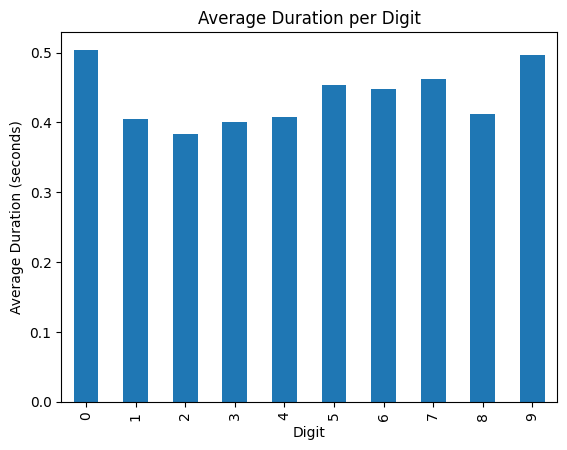


🧑 Duration by Speaker:
              mean    median       min       max       std
speaker                                                   
george    0.441717  0.430125  0.174875  0.999875  0.097588
jackson   0.516460  0.491687  0.344125  0.879750  0.107457
lucas     0.574211  0.541875  0.245625  1.313000  0.161731
nicolas   0.349188  0.348688  0.143625  0.574250  0.079630
theo      0.388862  0.369625  0.161000  2.282750  0.168451
yweweler  0.354168  0.347000  0.143500  0.683750  0.083247


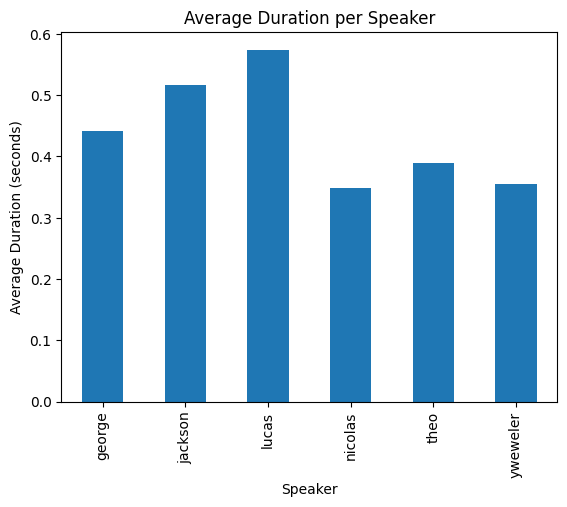

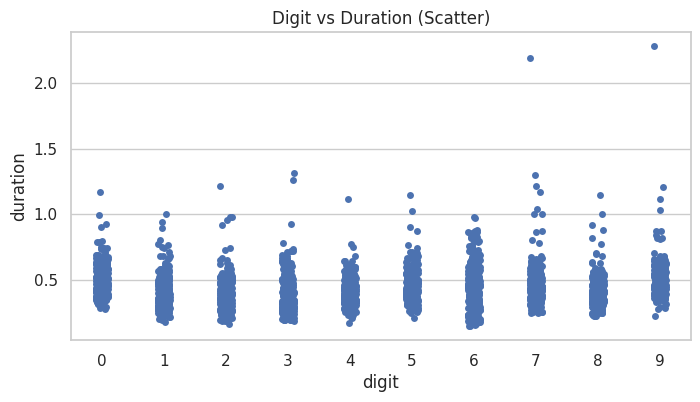

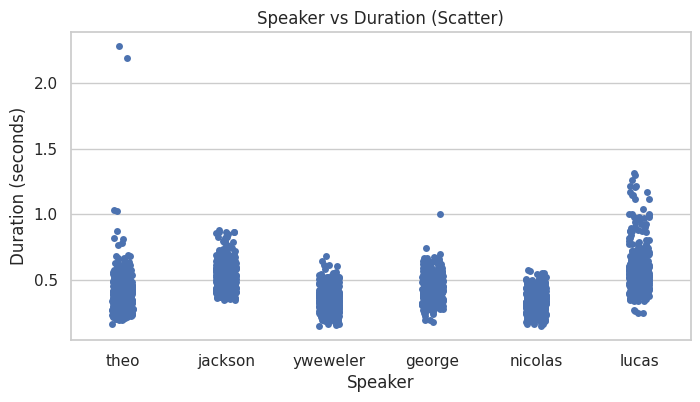

In [15]:
# Extract metadata
data_info = []
for f in files:
    digit, speaker, idx = f.replace('.wav', '').split('_')
    path = os.path.join(data_path, f)
    duration = librosa.get_duration(path=path)
    data_info.append([f, int(digit), speaker, int(idx), duration])

df = pd.DataFrame(data_info, columns=["filename", "digit", "speaker", "index", "duration"])

# Descriptive stats
print("🔢 General Stats:")
print(df[['digit', 'duration']].describe())

print("\n📊 Duration by Digit:")
print(df.groupby('digit')['duration'].agg(['mean', 'median', 'min', 'max', 'std']))

# Plot 1: Average Duration per Digit
df.groupby('digit')['duration'].mean().plot(kind='bar')
plt.title('Average Duration per Digit')
plt.xlabel('Digit')
plt.ylabel('Average Duration (seconds)')
plt.show()

print("\n🧑 Duration by Speaker:")
print(df.groupby('speaker')['duration'].agg(['mean', 'median', 'min', 'max', 'std']))

# Plot 2: Average Duration per Speaker
df.groupby('speaker')['duration'].mean().plot(kind='bar')

plt.title('Average Duration per Speaker')
plt.xlabel('Speaker')
plt.ylabel('Average Duration (seconds)')
plt.show()

# Set seaborn style
sns.set(style="whitegrid")



# Plot 3: Scatter Digit vs Duration
plt.figure(figsize=(8, 4))
sns.stripplot(x='digit', y='duration', data=df, jitter=True)
plt.title('Digit vs Duration (Scatter)')
plt.show()

# Plot 4: Scatter speaker vs Duration
plt.figure(figsize=(8, 4))
sns.stripplot(x='speaker', y='duration', data=df, jitter=True)
plt.title('Speaker vs Duration (Scatter)')
plt.xlabel('Speaker')
plt.ylabel('Duration (seconds)')
plt.show()




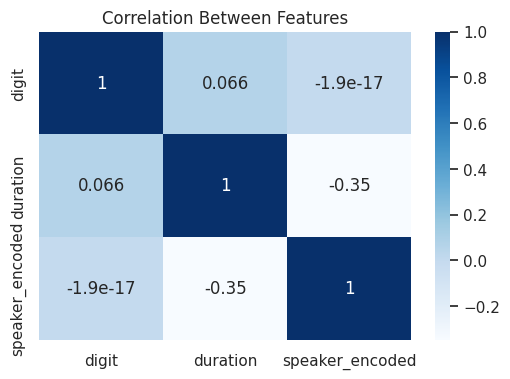

In [16]:
df['speaker_encoded'] = df['speaker'].astype('category').cat.codes

plt.figure(figsize=(6, 4))
sns.heatmap(df[['digit', 'duration', 'speaker_encoded']].corr(), annot=True, cmap='Blues')

plt.title("Correlation Between Features")
plt.show()


## Time-Domain Analysis

Detail the plan for extracting time-domain features (e.g., zero-crossing rate, RMS energy, etc.).

🎧 File: 5_george_7.wav
📏 Duration: 0.52 sec
⚡ RMS Energy (mean): 0.0610
🎚️ Zero-Crossing Rate (mean): 0.0743
📈 Temporal Envelope (mean): 0.0675
🔁 Autocorr[0:5]: [64.70213  61.116158 51.562756 38.967876 26.401989]


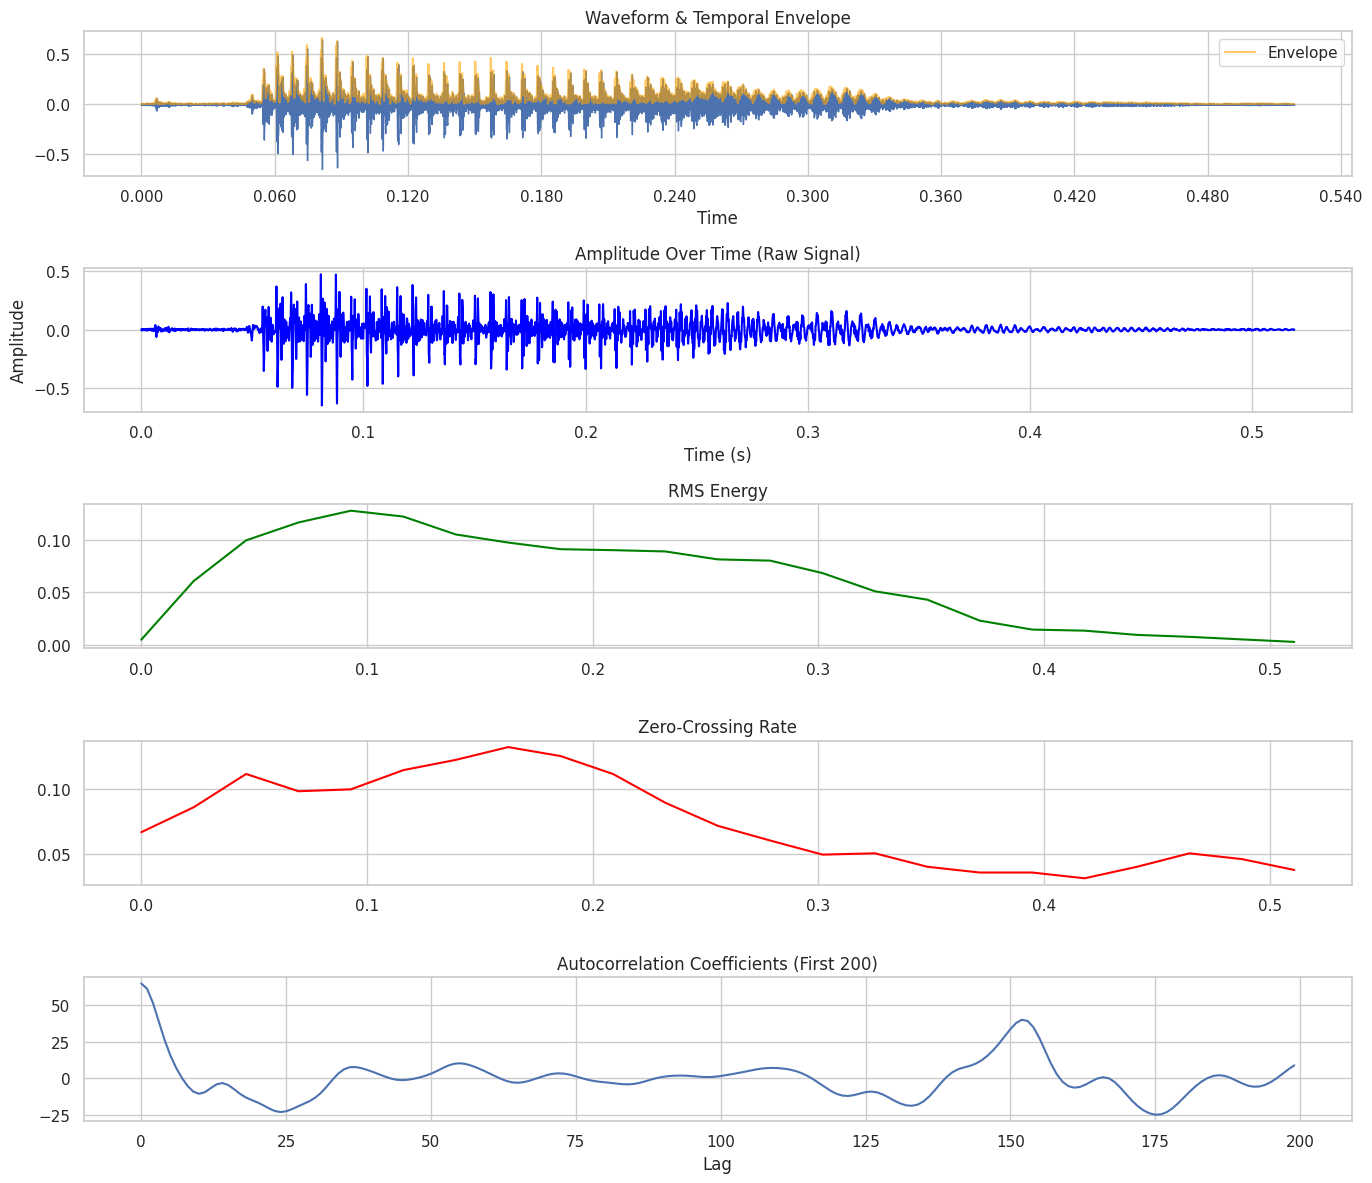

In [17]:
# Load sample
data_path = 'free-spoken-digit-dataset/recordings'
filename = np.random.choice(os.listdir(data_path))
filepath = os.path.join(data_path, filename)
y, sr = librosa.load(filepath)

# Duration
duration = librosa.get_duration(y=y, sr=sr)

# Time-domain features
rms = librosa.feature.rms(y=y)[0]
zcr = librosa.feature.zero_crossing_rate(y)[0]
times = librosa.times_like(rms, sr=sr)

# Temporal Envelope (Hilbert Transform method)
analytic_signal = hilbert(y)
amplitude_envelope = np.abs(analytic_signal)

# Autocorrelation coefficients (partial)
autocorr = np.correlate(y, y, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # Take second half

# Print key values
print(f"🎧 File: {filename}")
print(f"📏 Duration: {duration:.2f} sec")
print(f"⚡ RMS Energy (mean): {np.mean(rms):.4f}")
print(f"🎚️ Zero-Crossing Rate (mean): {np.mean(zcr):.4f}")
print(f"📈 Temporal Envelope (mean): {np.mean(amplitude_envelope):.4f}")
print(f"🔁 Autocorr[0:5]: {autocorr[:5]}")

# Visualization
plt.figure(figsize=(14, 12))

# 1. Waveform + Envelope
plt.subplot(5, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.plot(np.linspace(0, duration, len(amplitude_envelope)), amplitude_envelope, color='orange', alpha=0.6, label='Envelope')
plt.title("Waveform & Temporal Envelope")
plt.legend()

# 2. Raw Amplitude
plt.subplot(5, 1, 2)
plt.plot(np.linspace(0, duration, len(y)), y, color='blue')
plt.title("Amplitude Over Time (Raw Signal)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# 3. RMS Energy
plt.subplot(5, 1, 3)
plt.plot(times, rms, color='green')
plt.title("RMS Energy")

# 4. Zero-Crossing Rate
plt.subplot(5, 1, 4)
plt.plot(times, zcr, color='red')
plt.title("Zero-Crossing Rate")

# 5. Autocorrelation
plt.subplot(5, 1, 5)
plt.plot(autocorr[:200])
plt.title("Autocorrelation Coefficients (First 200)")
plt.xlabel("Lag")

plt.tight_layout()
plt.show()


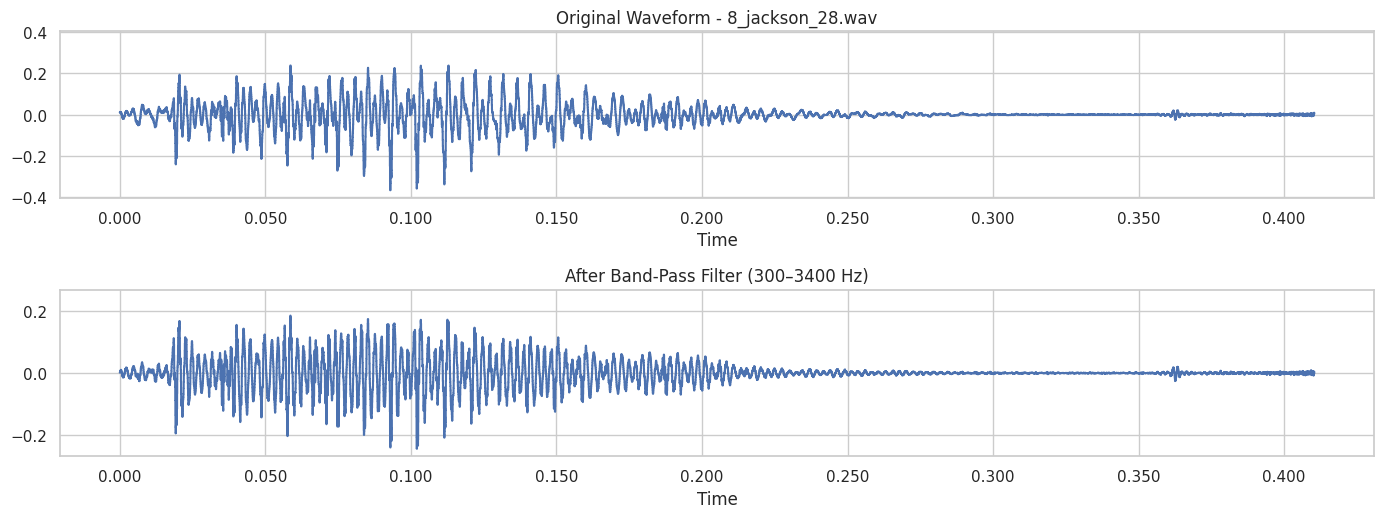

In [85]:
data_path = 'free-spoken-digit-dataset/recordings'
filename = np.random.choice([f for f in os.listdir(data_path) if f.endswith('.wav')])
filepath = os.path.join(data_path, filename)
y, sr = librosa.load(filepath)
# Band-pass filter (300–3400 Hz)
def bandpass_filter(signal, sr, lowcut=300, highcut=3400, order=4):
   nyq = 0.5 * sr
   low = lowcut / nyq
   high = highcut / nyq
   b, a = butter(order, [low, high], btype='band')
   return filtfilt(b, a, signal)
y_bandpass = bandpass_filter(y, sr)

# Plotting comparison
plt.figure(figsize=(14, 10))
# Original
plt.subplot(4, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title(f"Original Waveform - {filename}")
# Bandpass
plt.subplot(4, 1, 2)
librosa.display.waveshow(y_bandpass, sr=sr)
plt.title("After Band-Pass Filter (300–3400 Hz)")

plt.tight_layout()
plt.show()

In [50]:
# Parameters 
win_length  = 1024                 # samples 128 ms at 8 kHz
hop_length  =  256                 # WHich is the number of samples we shift 
n_fft       = 2048                 # zero pad to dpuble the window length
window_fun  = "hann"               


## Frequency-Domain Analysis

Describe the approach for performing frequency analysis (using STFT, spectral features, MFCCs, etc.).

In [51]:

#stft 
stft = librosa.stft(
    y,                            # my og signal
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window_fun,
    center=True,                   # padding and we are doing refelction at the borderes
    pad_mode="reflect"
)
magnitude = np.abs(stft)
S_db = librosa.amplitude_to_db(magnitude, ref=np.max)
print(f"STFT shape: {stft.shape}  →  frames × fft‑bins")
# using librosa I couldn't understand the code so I will do it from scratch using numpy

STFT shape: (1025, 26)  →  frames × fft‑bins


In [47]:
def cahdSTFT(y, win_length, hop_length, n_fft, window=np.hanning(1024)):
   
    pad = win_length // 2
    y_padded = np.pad(y, pad_width=(pad, pad), mode='reflect')

    # Number of frames
    num_frames = 1 + (len(y_padded) - win_length) // hop_length

    # Pre-allocate STFT matrix
    stft_matrix = np.empty((n_fft // 2 + 1, num_frames), dtype=np.complex64)

    for i in range(num_frames):
        start = i * hop_length
        end = start + win_length
        frame = y_padded[start:end]

        if len(frame) < win_length:
            frame = np.pad(frame, (0, win_length - len(frame)))

        windowed = frame * window
        spectrum = np.fft.rfft(windowed, n=n_fft)  # rfft since signal is real
        stft_matrix[:, i] = spectrum

    return stft_matrix


stft = stft_numpy(y)


magnitude = np.abs(stft)

# Convert to dB for more accurate observation
S_db = 20 * np.log10(magnitude / np.max(magnitude) )  


In [48]:
print(f"STFT shape: {stft.shape} → freq bins × frames")


STFT shape: (1025, 26) → freq bins × frames


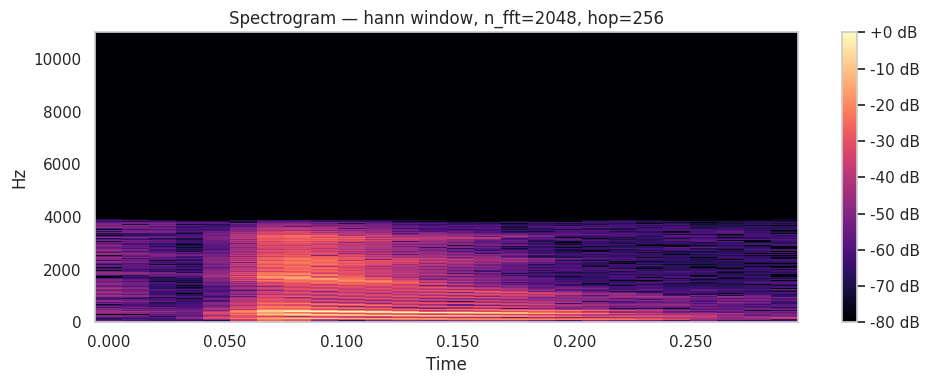

In [52]:
#spectogram visulising 
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    S_db,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="hz"
)
plt.colorbar(format="%+2.0f dB")
plt.title(f"Spectrogram — {window_fun} window, n_fft={n_fft}, hop={hop_length}")
plt.tight_layout()
plt.show()

# this is using librosa

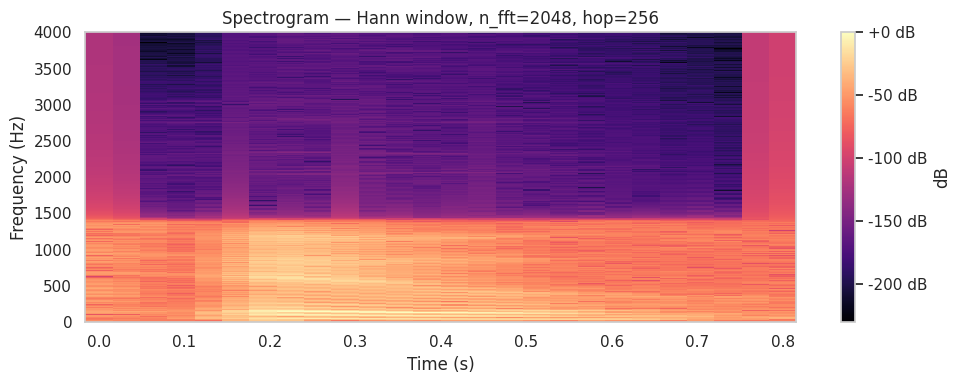

In [58]:
def CHADspectogram(S_db, sr, hop_length, n_fft, title="Spectrogram", cmap="magma"):
    time_axis = np.arange(S_db.shape[1]) * hop_length / sr
    freq_axis = np.linspace(0, sr / 2, S_db.shape[0])

    plt.figure(figsize=(10, 4))
    plt.pcolormesh(time_axis, freq_axis, S_db, shading="auto", cmap=cmap)
    plt.colorbar(format="%+2.0f dB", label="dB")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.tight_layout()
    plt.show()
magnitude = np.abs(stft)
S_db = 20 * np.log10(magnitude / np.max(magnitude) )

CHADspectogram(S_db, sr=8000, hop_length=256, n_fft=2048,
                 title="Spectrogram — Hann window, n_fft=2048, hop=256")

# this is using the from scratch STFT  

In [70]:
def compute_features(filepath):
    y, sr = librosa.load(filepath, sr=None)           # keep native 8 kHz

    # 1) Zero‑crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)[0].mean()

    # 2) RMS  &  3) Signal energy
    rms    = librosa.feature.rms(y=y)[0].mean()
    energy = np.sum(y**2) / len(y)

    # 4) Acceleration coefficients (Δ² MFCC)
    mfcc  = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    n_frames = mfcc.shape[1]

    # Choose a safe odd width (≥3) not larger than n_frames
    if n_frames >= 9:
        width = 9
        delta2 = librosa.feature.delta(mfcc, order=2, width=width, mode='interp')
    elif n_frames >= 3:
        width = n_frames if n_frames % 2 else n_frames - 1
        delta2 = librosa.feature.delta(mfcc, order=2, width=width, mode='interp')
    else:
        # Too few frames for any width ≥3 → fall back to 'nearest' padding
        delta2 = librosa.feature.delta(mfcc, order=2, mode='nearest')

    delta2_mu = delta2.mean(axis=1)   # 13‑D

    # 5) Temporal envelope stats
    envelope = np.abs(hilbert(y))
    env_mean, env_std = envelope.mean(), envelope.std()

    # Assemble final 18‑D vector
    return np.hstack([
        zcr, rms, energy, env_mean, env_std, delta2_mu
    ]).astype(np.float32)


## Wavelet Transform Analysis

Outline the method for applying wavelet transform techniques and extracting features.

In [ ]:
time_series, sample_rate = librosa.load('recordings/0_jackson_0.wav', duration=10)
plt.figure()
librosa.display.waveshow(time_series, sr=sample_rate)
plt.title('0_jackson_0.wav')

In [ ]:
def plot_mother_wavelet(wavelet_name='db4', level=1):
    """
    Plot the mother wavelet for a given wavelet.

    Parameters:
        wavelet_name (str): Name of the wavelet (e.g., 'db4', 'morl').
        level (int): Resolution parameter for wavefun (higher gives finer resolution default is 5).
    """
    wavelet = pywt.Wavelet(wavelet_name)
    phi, psi, x = wavelet.wavefun(level=level)

    
    plt.figure(figsize=(8, 4))
    plt.plot(x, psi)
    plt.title(f"Mother Wavelet: {wavelet_name}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_mother_wavelet('dmey', level=1)
plot_mother_wavelet('dmey', level=2)
plot_mother_wavelet('dmey', level=9)


In [ ]:
def extract_wavelet_features(audio_data, wavelet, levels=5):
    """
    Compute discrete wavelet features from a raw audio signal.
    
    Parameters:
        audio_data (numpy.ndarray): 1D array of raw audio samples.
        wavelet (str): Wavelet type to use.
        levels (int, optional): Number of decomposition levels (default 5).
    
    Returns:
        tuple that contains:
              - 'coefficients': list of arrays for each decomposition level.
              - 'energies': energy for each level.
    
    Example:
        features = extract_wavelet_features(audio, wavelet='db4', levels=4)
    """
    coeffs = pywt.wavedec(audio_data, wavelet, level=levels)
    
    energies = [np.sum(c ** 2) for c in coeffs] #List comprehension (ISE291)
        
    return (coeffs,energies)

In [ ]:
wavelet_features = extract_wavelet_features(time_series,'haar',6)

In [ ]:
def plot_wavelet_scalogram_from_features(features, original_length,title):
    """
    Plot a wavelet scalogram from wavelet features (coefficients) without any axes, colorbar, or padding.
    
    Parameters:
        features (tuple): Must contain wavelet coefficients in features[0].
                                 Assumes they're in the order [Approximation, Detail_n, ..., Detail_1].
        original_length (int):   Number of samples in the original 1-second signal.
        title (string): The name of png file
        
    Returns:
        None. Displays a borderless plot with no axes or legends.
    """
    coeffs = features[0]  
    num_levels = len(coeffs)

    # Prepare a 2D array for the scalogram
    scalogram = np.zeros((num_levels, original_length))

    # We'll treat the signal as lasting from 0 to 1s
    x_target = np.linspace(0, 1, original_length)

    # Interpolate each coefficient array onto the same (0→1) axis
    for i, c in enumerate(coeffs):
        x_row = np.linspace(0, 1, len(c))
        scalogram[i, :] = np.interp(x_target, x_row, np.abs(c))

    #Normalization    
    for i in range(num_levels):
        max_val = np.max(scalogram[i, :])
        if max_val > 0:
            scalogram[i, :] = scalogram[i, :]/max_val

    # Create the figure of scalo
    fig, ax = plt.subplots(figsize=(2.24, 2.24))  
    # Plot the scalogram 
    ax.imshow(scalogram, aspect="auto", cmap="jet", extent=[0, 1, 0, num_levels], origin="lower")

    # Remove all axes
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    #plt.show()

    fig.savefig(f'{title}.png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)

In [ ]:
plot_wavelet_scalogram_from_features(wavelet_features, len(time_series),'Scalo0_haar') #For one sample only

In [ ]:
def dir_to_scalograms(audio_dir, scalogram_dir):
    """
    Creates spectrogram images for all audio files in the specified directory and saves them.

    Parameters:
        audio_dir (str): Path to the directory containing the input audio files.
        spectrogram_dir (str): Path to the directory where the spectrogram images will be saved.

    Returns:
        None

    Example:
        dir_to_spectrogram("audio_recordings/", "output_scalograms/")
    """
    #print([f for f in os.listdir('recordings')])
    #listr = []
    file_names = [f for f in os.listdir(audio_dir)]
    for file in file_names:
        #print('recordings/'+file)
        time_series, sample_rate = librosa.load('recordings/'+file, duration=10)
        features = extract_wavelet_features(time_series,'haar',6)
        image_Name = scalogram_dir + '/' + file.replace('.wav','')+'_Scalogram'
        #print(image_Name)
        plot_wavelet_scalogram_from_features(features,len(time_series),image_Name)

In [ ]:
#This should'nt run again because it takes a lot of time
#dir_to_scalograms('recordings', 'Scalograms')

## Classification System

Plan the design and evaluation of the classification system, including feature selection, model choice, and performance metrics.

In [72]:
x = []   # Features
y = []   # Labels

DATASET_PATH = "free-spoken-digit-dataset/recordings"

for filename in files:
    filepath = os.path.join(DATASET_PATH, filename)

    features = compute_features(filepath)       
    label    = filename.split('_')[0]            # digit is the first token

    x.append(features)
    y.append(int(label))

x = np.array(x, dtype=np.float32)
y = np.array(y)

# alias so your next cell can still call 'X'
X = x



KNN Accuracy: 0.80


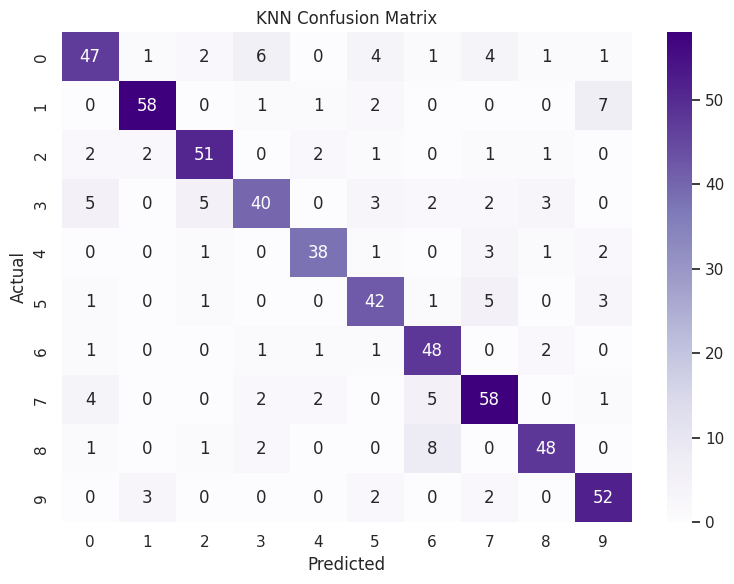

Accuracy: 0.69


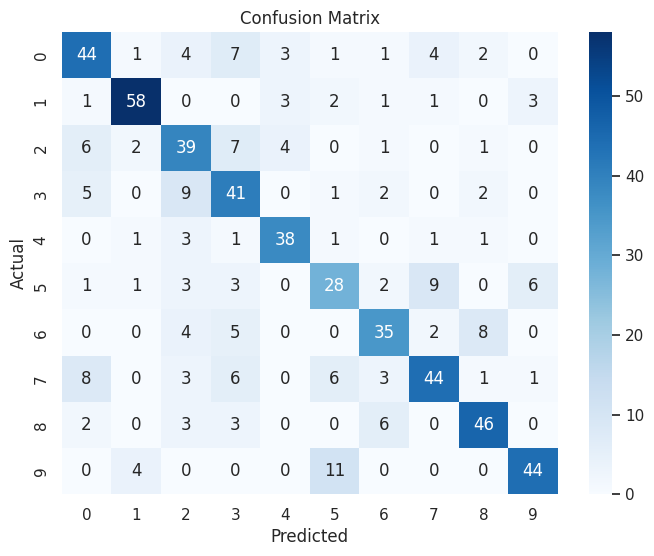

In [84]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Support vector machine (SVM) classifer:
SVM = SVC(kernel='linear', C=1.0)
#Try different kernel:
#1) SVM = SVC(kernel='rbf', C=1.0)
#2)  SVM = SVC(kernel='poly',, degree=3, C=1.0) 
SVM.fit(x_train, y_train)
#K-nn Classfier:

KNN = KNeighborsClassifier(n_neighbors=5, weights='distance')  # try n_neighbors=3, 7 etc.
KNN.fit(x_train, y_train)

# Evaluate KNN
y_knn_pred = KNN.predict(x_test)
knn_acc = accuracy_score(y_test, y_knn_pred)
print(f"\nKNN Accuracy: {knn_acc:.2f}")

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_knn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.show()
# Evaluate the support vector machine (SVM) classfier:
y_pred = SVM.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1541
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1960
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(
/home/haky/myenv/lib/python3

Epoch 01 | Val Acc: 0.422
Epoch 02 | Val Acc: 0.510
Epoch 03 | Val Acc: 0.557
Epoch 04 | Val Acc: 0.602
Epoch 05 | Val Acc: 0.648
Epoch 06 | Val Acc: 0.678
Epoch 07 | Val Acc: 0.703
Epoch 08 | Val Acc: 0.715
Epoch 09 | Val Acc: 0.715
Epoch 10 | Val Acc: 0.735
Epoch 11 | Val Acc: 0.748
Epoch 12 | Val Acc: 0.743
Epoch 13 | Val Acc: 0.750
Epoch 14 | Val Acc: 0.783
Epoch 15 | Val Acc: 0.758
Epoch 16 | Val Acc: 0.773
Epoch 17 | Val Acc: 0.787
Epoch 18 | Val Acc: 0.770
Epoch 19 | Val Acc: 0.775
Epoch 20 | Val Acc: 0.783
Epoch 21 | Val Acc: 0.795
Epoch 22 | Val Acc: 0.802
Epoch 23 | Val Acc: 0.807
Epoch 24 | Val Acc: 0.798
Epoch 25 | Val Acc: 0.810
Epoch 26 | Val Acc: 0.813
Epoch 27 | Val Acc: 0.815
Epoch 28 | Val Acc: 0.817
Epoch 29 | Val Acc: 0.807
Epoch 30 | Val Acc: 0.810


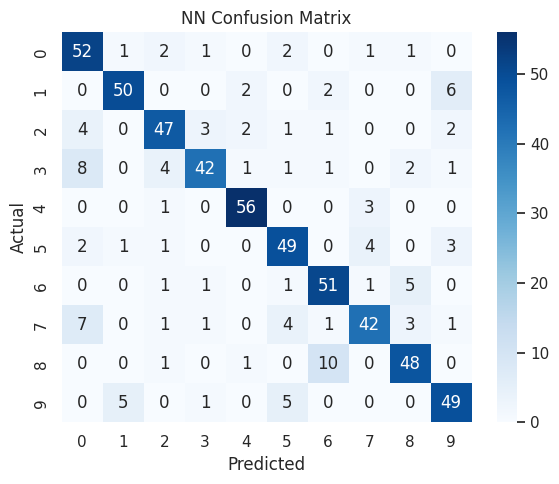

Final Accuracy: 0.810


In [82]:
x, y = [], []
x, y = [], []

for row in df.itertuples(index=False):
    # Use the correct path column
    if hasattr(row, 'filepath'):
        path = row.filepath
    elif hasattr(row, 'filename'):
        path = os.path.join('free-spoken-digit-dataset/recordings', row.filename)
    else:
        raise ValueError("Your dataframe must contain 'filepath' or 'filename' column.")

    features = compute_features(path)
    x.append(features)
    y.append(row.digit)

# 2. Train/Val Split
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Convert to torch tensors
X_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
X_val   = torch.tensor(x_val)
y_val   = torch.tensor(y_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)
X_val,   y_val   = X_val.to(device),   y_val.to(device)

# 4. Define NN
model = torch.nn.Sequential(
    torch.nn.Linear(18, 64), torch.nn.ReLU(),
    torch.nn.Linear(64, 64), torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. Training loop
EPOCHS = 30
BATCH_SIZE = 64

for epoch in range(1, EPOCHS+1):
    model.train()
    idx = torch.randperm(X_train.size(0))
    Xb, yb = X_train[idx], y_train[idx]

    for i in range(0, len(yb), BATCH_SIZE):
        xb_batch = Xb[i:i+BATCH_SIZE]
        yb_batch = yb[i:i+BATCH_SIZE]

        optimizer.zero_grad()
        preds = model(xb_batch)
        loss = loss_fn(preds, yb_batch)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val).argmax(dim=1)
        acc = (val_preds == y_val).float().mean().item()
    print(f"Epoch {epoch:02d} | Val Acc: {acc:.3f}")

# 6. Confusion Matrix
preds = val_preds.cpu().numpy()
y_val_np = y_val.cpu().numpy()

cm = confusion_matrix(y_val_np, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("NN Confusion Matrix")
plt.tight_layout(); plt.show()

print(f"Final Accuracy: {accuracy_score(y_val_np, preds):.3f}")

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# 1) Define your transforms once
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# 2) Prepare empty lists
train_imgs, train_labels = [], []
val_imgs,   val_labels   = [], []
class_names = [str(i) for i in range(10)]

# 3) Loop over your scalogram PNGs
root = 'Scalograms/'
for fname in os.listdir(root):
    # expect "digit_person_sample#_Scalogram.png"
    digit_str, person, sample_str, tag_png = fname.split('_')

    digit     = int(digit_str)
    sample_no = int(sample_str)
    img = Image.open(os.path.join(root, fname)).convert('RGB')
    img_t = transform(img)

    # split: sample# <5 → val, else → train
    if sample_no < 5:
        val_imgs.append(img_t);   val_labels.append(digit)
    else:
        train_imgs.append(img_t); train_labels.append(digit)

# 4) Stack into tensors
train_x = torch.stack(train_imgs)                 
train_y = torch.tensor(train_labels, dtype=torch.long)
val_x   = torch.stack(val_imgs)
val_y   = torch.tensor(val_labels,   dtype=torch.long)

# 5) Wrap in TensorDataset + DataLoader
batch_size = 8
train_loader = DataLoader(TensorDataset(train_x, train_y),
                          batch_size=batch_size,
                          shuffle=True,  num_workers=4)
val_loader   = DataLoader(TensorDataset(val_x,   val_y),
                          batch_size=batch_size,
                          shuffle=False, num_workers=4)

print(f"Train samples: {len(train_y)},  Val samples: {len(val_y)}")
#print(train_y)

Train samples: 2700,  Val samples: 300


In [3]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1) Build your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)   # 10 classes for digits 0–9
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
num_epochs = 8

# 2) Your existing DataLoaders
# train_loader, val_loader = get your loaders...
dataloaders = {
    'train': train_loader,
    'val':   val_loader
}
dataset_sizes = {
    'train': len(train_loader.dataset),
    'val':   len(val_loader.dataset)
}

# 3) Training loop
since = time.time()
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()
        else:
            model_ft.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc  = running_corrects / dataset_sizes[phase]
        print(f'{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')

        # track best validation accuracy
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc

    print()

time_elapsed = time.time() - since
mins = time_elapsed // 60
secs = time_elapsed % 60
print(f'Training complete in {mins:.0f}m {secs:.0f}s')
print(f'Best val Acc: {best_acc:.4f}')


Epoch 1/8
--------------------
train Loss: 1.3331  Acc: 0.5363
val Loss: 0.5772  Acc: 0.7967

Epoch 2/8
--------------------
train Loss: 0.5314  Acc: 0.8259
val Loss: 0.4433  Acc: 0.8233

Epoch 3/8
--------------------
train Loss: 0.3051  Acc: 0.9030
val Loss: 0.2911  Acc: 0.9133

Epoch 4/8
--------------------
train Loss: 0.1720  Acc: 0.9459
val Loss: 0.3450  Acc: 0.8767

Epoch 5/8
--------------------
train Loss: 0.1564  Acc: 0.9496
val Loss: 0.2191  Acc: 0.9267

Epoch 6/8
--------------------
train Loss: 0.1075  Acc: 0.9648
val Loss: 0.2045  Acc: 0.9333

Epoch 7/8
--------------------
train Loss: 0.0737  Acc: 0.9819
val Loss: 0.3558  Acc: 0.9000

Epoch 8/8
--------------------
train Loss: 0.0573  Acc: 0.9833
val Loss: 0.3128  Acc: 0.9167

Training complete in 114m 47s
Best val Acc: 0.9333


In [4]:
#Save the model after training to avoid mistakes (happend to me once and had to retrain)
PATH = './cnn_net.pth'
torch.save(model_ft.state_dict(), PATH)

In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(model, dataloader, class_names, device):
    """
    Computes and plots both the raw and normalized confusion matrices for `model` on `dataloader`,
    and prints the overall accuracy.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # gather predictions and labels
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # compute CM and accuracy
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')
    accuracy = cm.diagonal().sum() / cm.sum()
    print(f'Overall accuracy: {accuracy:.2%}')

    # wrap in DataFrames for labeling
    cm_df      = pd.DataFrame(cm,      index=class_names, columns=class_names)
    cm_norm_df = pd.DataFrame(cm_norm, index=class_names, columns=class_names)

    # plot raw confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_df, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Acc: {accuracy:.2%})')
    plt.tight_layout()
    plt.show()

    # plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_norm_df, annot=True, fmt='.2f', cmap='Blues', cbar=False,
        xticklabels=class_names, yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.show()

Overall accuracy: 91.67%


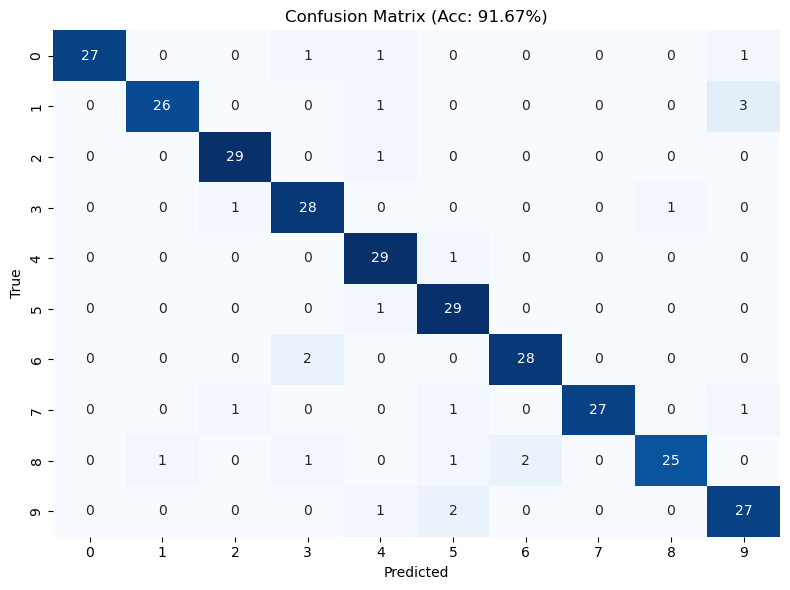

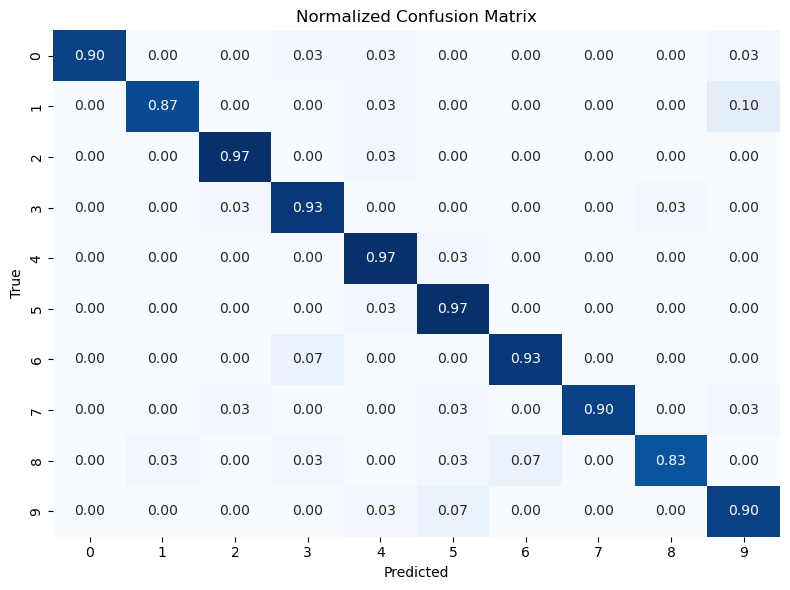

In [6]:
plot_confusion_matrix(model_ft, dataloaders['val'], class_names, device)

## Conclusion
- In conclusion, we were able to classify digits based on multiple feeatures including time-domain features, frequency domain features and wavelet features
- Multiple models were used to give us different prespectives onto the problem of classfication